# DCMIP test case 4 demo
-------

Here, the ability of the dynamical core to maintain a balanced state is
tested. The initial conditions are analytically derived to be a steady
state solution of the primitive equations on a sphere (Jablonowski and Williamson (2006)).

Jablonowski's group provides a fortran file which generates the initial conditions
to test any dynamical core. We have written a Cython wrapper around it, and use it to
start the simulation.

Using netCDF4 interface for IO
Lats, lons, levs, trunc, dims, tracers 62 128 28 40 861 1


<IPython.core.display.Javascript object>


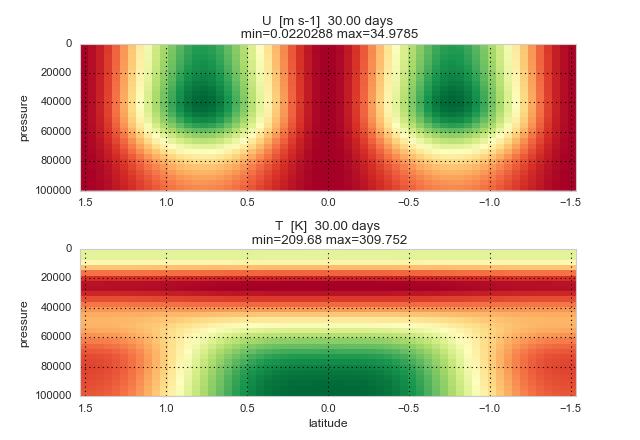

In [1]:
%matplotlib notebook

from climt.dynamics import dynamics
from climt.dcmip import getBaroclinicWaveICs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid',rc={'grid.linestyle':'dotted', 'grid.color':'0.0'})
# Dynamical core parameters

kwargs = {}
kwargs['dt'] = 1200
kwargs['nlon'] = 128
kwargs['nlat'] = 62
kwargs['MonitorFields'] = ['U','T'] # Display zonal velocity during simulation
kwargs['MonitorFreq'] = 6.*3600 #6 hourly update

#Init the dynamics Component
dycore = dynamics(scheme='gfs', **kwargs)

#Get the pressure and lat/lon values; this is needed
#to generate the initial conditions
pressure = dycore['p']
ps = dycore['ps']

full_latitudes = dycore.Extension.latitudes
full_longitudes = dycore.Extension.longitudes

#Get new initial conditions
u,v,t, phis = getBaroclinicWaveICs(pressure, full_longitudes, full_latitudes)

#Initialise model topography
dycore.Extension.set_topography(phis)

#Initialise winds, surface pressure and temperature
dycore.Extension.initial_conditions(u,v,t,ps)

#Run the code for 30 days. each time step is 1200 seconds = 1/3 hour
num_steps = 30*24*3

#Store error between integrated and initial zonal mean zonal wind
error = np.zeros(num_steps)

u_init = np.average(u, axis=0)

for i in range(num_steps):
    #Go ahead one time step
    dycore.step()
    
    #Get the new value of zonal mean zonal wind
    u_new = np.average(dycore['U'], axis=0)
    
    #Calculate the error
    error[i] = np.sqrt(np.mean((u-u_new)**2))
    
# Delete reference to deallocate fortran data
del(dycore)

<IPython.core.display.Javascript object>


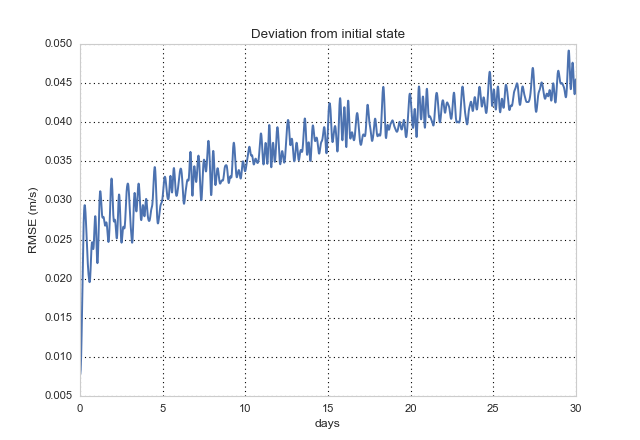

In [2]:
plt.figure()

plt.plot(np.arange(num_steps)/(24.*3),  error)
plt.title('Deviation from initial state')
plt.xlabel('days')
plt.ylabel('RMSE (m/s)')